In [78]:
using Revise
using LinearAlgebra
using Statistics
includet("utils.jl")
config_dict = YAML.load_file("../experiment_config.yml")

Dict{Any, Any} with 12 entries:
  "y_var_names"   => ["thetaa", "hur", "hus", "cl", "clw", "rlut", "rlutcs", "r…
  "prior"         => "prior.toml"
  "batch_size"    => 1
  "output_dir"    => "output/local_calibration"
  "g_t_start_sec" => 72000.0
  "g_t_end_sec"   => 144000.0
  "ensemble_size" => 100
  "noise"         => "obs_noise_cov.jld2"
  "observations"  => "observations.jld2"
  "n_iterations"  => 10
  "model_config"  => "model_config.yml"
  "dims"          => 9

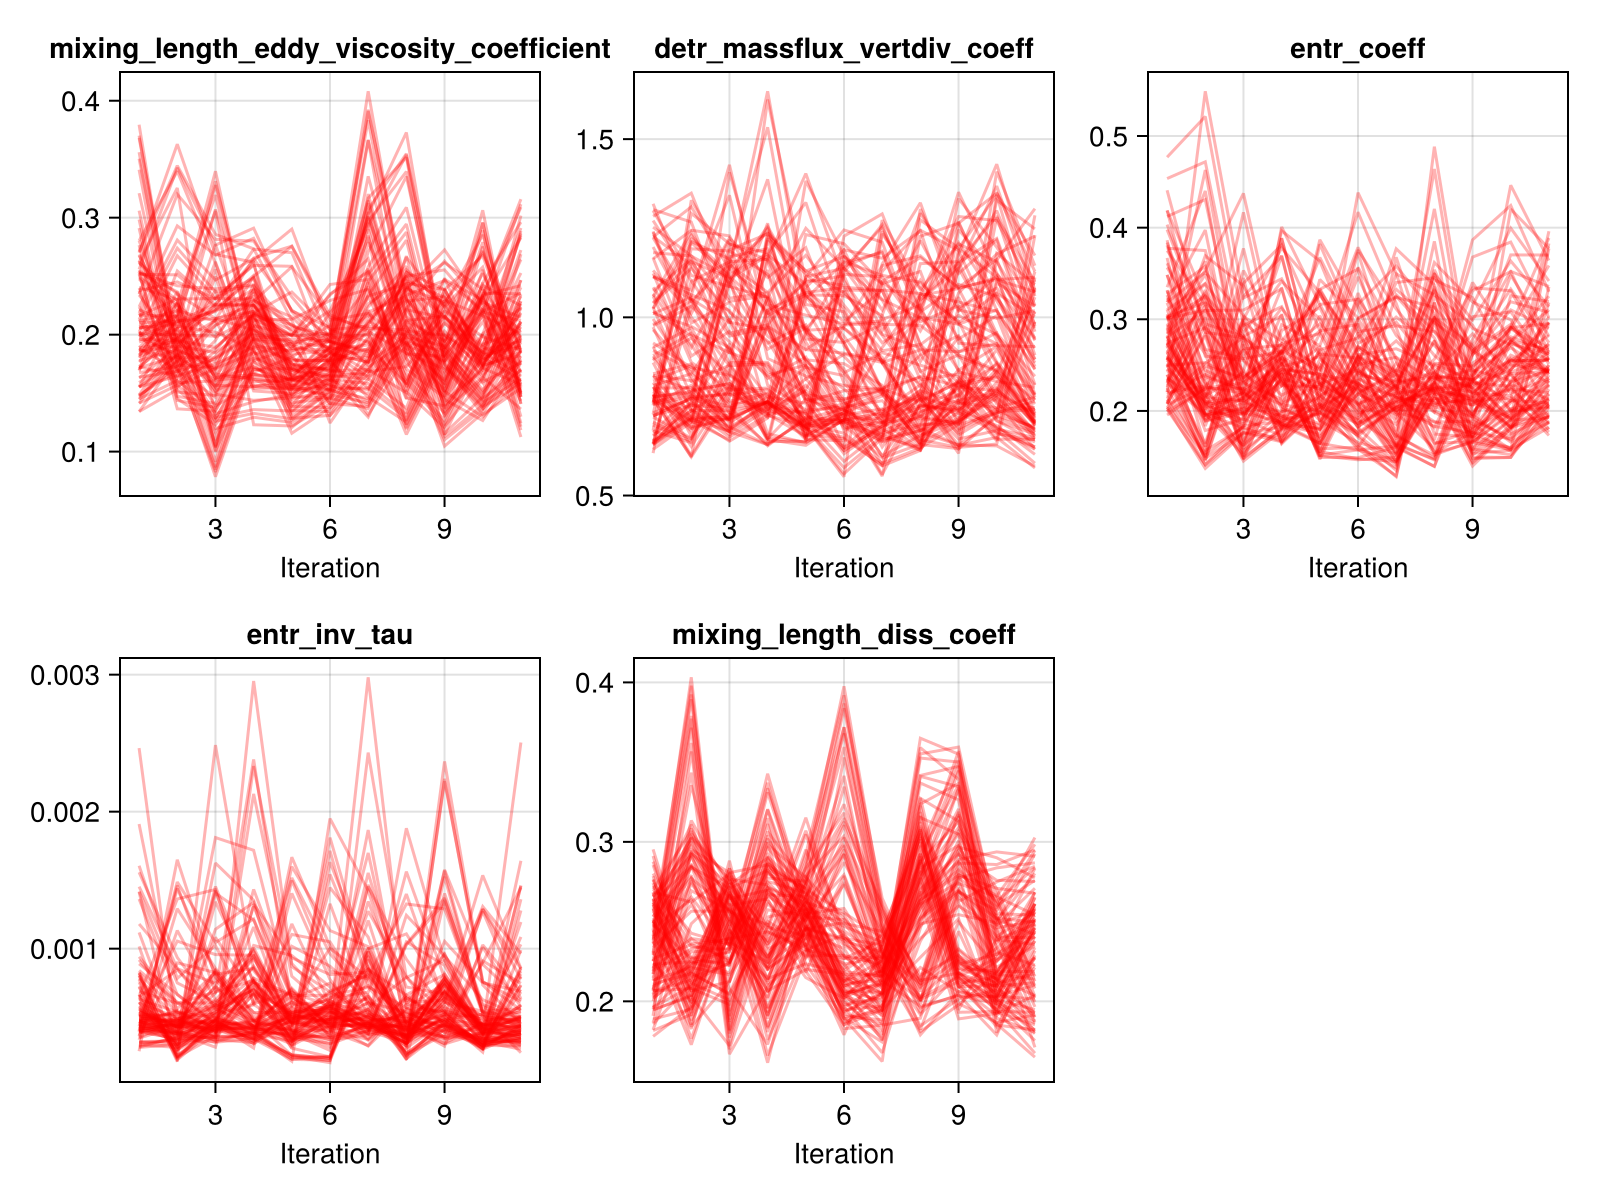

In [20]:
plot_parameters(10, "../output/local_calibration")

In [24]:
# functionalize the 
iteration =10
output_dir = joinpath("../output", "local_calibration")
eki_filepath = joinpath(CAL.path_to_iteration(output_dir, iteration), "eki_file.jld2")
eki = JLD2.load_object(eki_filepath)
loss_vals = EKP.get_g(eki)

10-element Vector{Matrix{Float64}}:
 [405.7777099609375 405.7177734375 … 405.7222595214844 405.71905517578125; 0.36254528164863586 0.3643397390842438 … 0.3611162304878235 0.36383533477783203; … ; 271.1990966796875 274.06744384765625 … 274.12408447265625 274.32452392578125; 123.15431213378906 123.12553405761719 … 123.09632110595703 123.12672424316406]
 [405.7168884277344 405.7239685058594 … 405.7114562988281 405.72467041015625; 0.3640116751194 0.36122509837150574 … 0.36038002371788025 0.3606519103050232; … ; 273.6890869140625 273.9654846191406 … 264.1988220214844 274.2648620605469; 123.11697387695312 123.09219360351562 … 123.02803039550781 123.09436798095703]
 [405.720703125 405.7209167480469 … 405.72503662109375 405.7171325683594; 0.3618343472480774 0.36053788661956787 … 0.3588651716709137 0.35911262035369873; … ; 274.7691650390625 273.7567138671875 … 267.76513671875 266.6040954589844; 123.09950256347656 123.09150695800781 … 123.03874206542969 123.03874206542969]
 [405.7213439941406 40

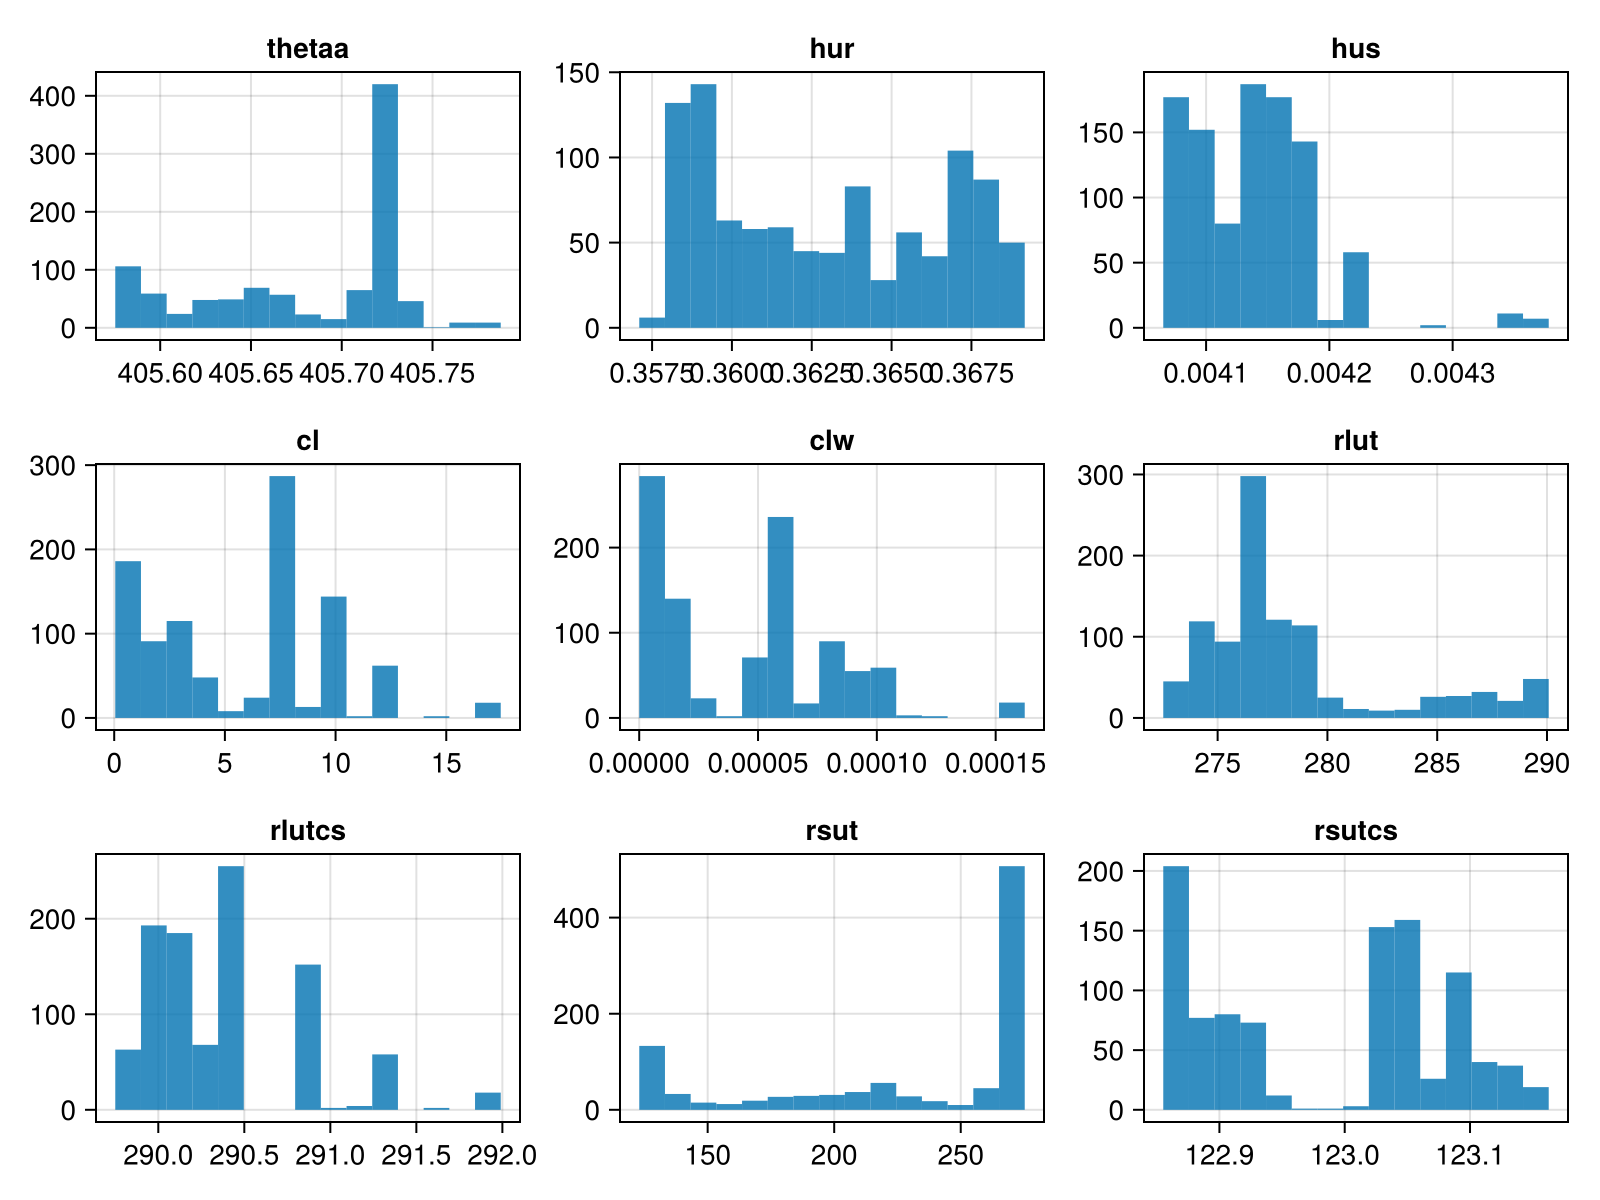

In [73]:
# plot histograms of simulations
var_mat = hcat(loss_vals...)
fig = Figure(size = (800, 600))
num_per_row = 3
for i in 1:9
    row = div(i-1, num_per_row) + 1
    col = mod(i-1, num_per_row) + 1
    
    ax = Axis(fig[row, col], title = config_dict["y_var_names"][i])
    
    hist!(ax, var_mat[i, :])
end
fig


In [93]:
function gen_obs(simdir = "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active")
    simdir = SimDir(simdir)
    process_member_data(simdir; y_names = config_dict["y_var_names"], t_start = config_dict["g_t_start_sec"], t_end = config_dict["g_t_end_sec"])
end
observations = gen_obs()
JLD2.save_object("../observations.jld2", observations)

In [97]:
obs_vars = [.3, .036, .00042, 5, 5e-5, 1, 1, 1, 1]
JLD2.save_object("../obs_noise_cov.jld2", Diagonal(obs_vars))

In [96]:
# load observations 
obs = JLD2.load_object("../observations.jld2")
obs_cov = JLD2.load_object("../obs_noise_cov.jld2")

9×9 Diagonal{Float64, Vector{Float64}}:
 0.0863326   ⋅        ⋅           ⋅       …   ⋅           ⋅        ⋅ 
  ⋅         1.23893   ⋅           ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅       7.18732e-7   ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅          2.92695      ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅       …   ⋅           ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅          0.00360234   ⋅        ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅          4.13139   ⋅ 
  ⋅          ⋅        ⋅           ⋅           ⋅           ⋅       2.74378

In [40]:
# process member data
config_dict = YAML.load_file("../experiment_config.yml")

Dict{Any, Any} with 12 entries:
  "y_var_names"   => ["thetaa", "hur", "hus", "cl", "clw", "rlut", "rlutcs", "r…
  "prior"         => "prior.toml"
  "batch_size"    => 1
  "output_dir"    => "output/local_calibration"
  "g_t_start_sec" => 72000.0
  "g_t_end_sec"   => 144000.0
  "ensemble_size" => 100
  "noise"         => "obs_noise_cov.jld2"
  "observations"  => "observations.jld2"
  "n_iterations"  => 10
  "model_config"  => "model_config.yml"
  "dims"          => 9

In [59]:
simdir = SimDir("../../perf_gcm_driven_scm/output/gcm_driven_scm/output_0010")
process_member_data(simdir; y_names = config_dict["y_var_names"], t_start = config_dict["g_t_start_sec"], t_end = config_dict["g_t_end_sec"])

1-element Vector{Float64}:
 306.3287353515625

SimDir{Dict{Any, Any}, Dict{Any, Any}}("../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active", Dict{Any, Any}("tke" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/tke_10m_inst.nc")), "hus" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/hus_10m_inst.nc")), "rlut" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/rlut_10m_inst.nc")), "rsut" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/rsut_10m_inst.nc")), "thetaa" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/thetaa_10m_inst.nc")), "waup" => Dict{Any, Any}("inst" => Dict{Any, Any}("10m" => "../../perf_gcm_driven_scm/output/gcm_driven_scm/output_active/waup_10m_inst.nc")), "detr" => Dict{Any, Any